In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

Using TensorFlow backend.


In [2]:
# getting data
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [5]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df, RNN=True)


In [6]:
corpus_df.head()


,text
0,test predict breast cancer relapse approved
1,two hussein allies hanged iraqi official says
2,sights sounds ces
3,schuey sees ferrari unveil new car
4,closings cancellations top advice flu outbreak


In [7]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,label
0,0,0,15,38,9,11,joy,3
1,24,26,16,13,38,5,sadness,4
2,0,0,0,17,0,4,joy,3
3,0,0,0,46,0,31,joy,3
4,1,0,23,8,11,8,fear,2


In [14]:
length = []
for i in corpus_df['text']:
    length.append(len(i.split()))
max(length)

10

## RNN: Emotion Labels

In [15]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)

In [16]:
X = corpus_df['text']
y = emotion_df['label']

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(X)
# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [17]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]


In [18]:
random.seed(2)
train_list = np.random.choice(range(0,1000), size=750, replace=False)
test_list = [i for i in range(0,1000) if i not in train_list]

X_train = padded_X[train_list]
X_test = padded_X[test_list]


# labels one hot encoded
y_train = pd.get_dummies(y.iloc[train_list]).values
y_test = pd.get_dummies(y.iloc[test_list]).values

# y_train_binary = keras.utils.to_categorical(y_train, 6)
# y_test_binary = keras.utils.to_categorical(y_test, 6)


In [19]:
X_train[0]

array([   0,    0,    0,    0,    0,    0, 2605,   99,  276,  474],
      dtype=int32)

In [30]:
model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])



history = model.fit(X_train, 
                    y_train,
                    epochs=20,
                    batch_size=75,
                    validation_data=(X_test, y_test))



Train on 750 samples, validate on 250 samples
Epoch 1/12
750/750 [==============================] - 4s 5ms/step - loss: 0.1787 - acc: 0.1760 - val_loss: 0.1381 - val_acc: 0.2960
Epoch 2/12
750/750 [==============================] - 0s 583us/step - loss: 0.1573 - acc: 0.2653 - val_loss: 0.1297 - val_acc: 0.3120
Epoch 3/12
750/750 [==============================] - 1s 827us/step - loss: 0.1487 - acc: 0.3107 - val_loss: 0.1231 - val_acc: 0.3920
Epoch 4/12
750/750 [==============================] - 0s 566us/step - loss: 0.1370 - acc: 0.3613 - val_loss: 0.1187 - val_acc: 0.3960
Epoch 5/12
750/750 [==============================] - 0s 648us/step - loss: 0.1358 - acc: 0.3747 - val_loss: 0.1181 - val_acc: 0.4280
Epoch 6/12
750/750 [==============================] - 0s 538us/step - loss: 0.1193 - acc: 0.4493 - val_loss: 0.1161 - val_acc: 0.4600
Epoch 7/12
750/750 [==============================] - 0s 588us/step - loss: 0.1163 - acc: 0.4760 - val_loss: 0.1132 - val_acc: 0.4720
Epoch 8/12
750/750

In [31]:
model.evaluate(X_test, y_test)

250/250 [==============================] - 0s 225us/step


[0.10232255750894546, 0.5479999995231628]

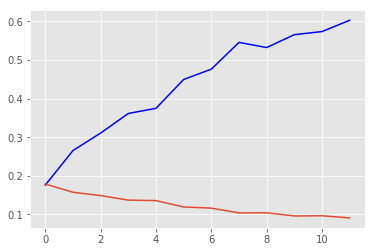

In [32]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')

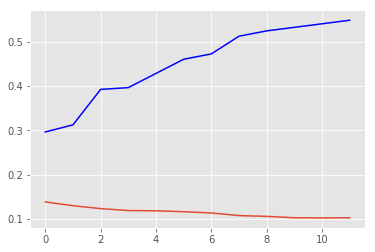

In [33]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')

In [34]:
preds = model.predict_on_batch(X_test)

emotion_preds = pd.DataFrame({"Prediction Anger":preds[:,0], "Prediction Disgust":preds[:,1], "Prediction Fear":preds[:,2], "Prediction Joy":preds[:,3], "Prediction Sadness":preds[:,4], "Prediction Surprise":preds[:,5], "Anger":y_test[:,0], "Disgust":y_test[:,1], "Fear": y_test[:,2], "Joy": y_test[:,3], "Sadness": y_test[:,4], "Surprise": y_test[:,5]})
emotion_preds.head()

,Prediction Anger,Prediction Disgust,Prediction Fear,Prediction Joy,Prediction Sadness,Prediction Surprise,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,0.069849,0.121922,0.072698,0.386461,0.060868,0.288203,0,0,0,1,0,0
1,0.014208,0.026112,0.027398,0.844530,0.022233,0.065521,0,0,0,1,0,0
2,0.041568,0.059820,0.027510,0.028614,0.193069,0.649419,0,0,0,0,1,0
3,0.002495,0.008394,0.024994,0.929377,0.017122,0.017618,0,0,0,1,0,0
4,0.002182,0.003287,0.002185,0.000278,0.991282,0.000786,0,0,0,0,1,0


# RNN with Valence Labels

In [134]:
X = corpus_df['text']
y = valence_df['label']

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
sequences = tokenizer.texts_to_sequences(X)
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [149]:
random.seed(3)
train_list = np.random.choice(range(0,1000), size=750, replace=False)
test_list = [i for i in range(0,1000) if i not in train_list]

X_train = padded_X[train_list]
X_test = padded_X[test_list]

# labels one hot encoded
y_train = (y.iloc[train_list]).values
y_test = (y.iloc[test_list]).values

y_train_binary = keras.utils.to_categorical(y_train, 3)
y_test_binary = keras.utils.to_categorical(y_test, 3)

X_train

model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train_binary,
                    epochs=20,
                    batch_size=75,
                    validation_data=(X_test, y_test_binary))


Train on 750 samples, validate on 250 samples
Epoch 1/20
750/750 [==============================] - 10s 13ms/step - loss: 0.2845 - acc: 0.4040 - val_loss: 0.2145 - val_acc: 0.5480
Epoch 2/20
750/750 [==============================] - 0s 593us/step - loss: 0.2296 - acc: 0.4973 - val_loss: 0.2106 - val_acc: 0.5760
Epoch 3/20
750/750 [==============================] - 1s 798us/step - loss: 0.1992 - acc: 0.5693 - val_loss: 0.1951 - val_acc: 0.5920
Epoch 4/20
750/750 [==============================] - 0s 573us/step - loss: 0.1724 - acc: 0.6533 - val_loss: 0.1955 - val_acc: 0.5960
Epoch 5/20
750/750 [==============================] - 1s 829us/step - loss: 0.1606 - acc: 0.6547 - val_loss: 0.1823 - val_acc: 0.6160
Epoch 6/20
750/750 [==============================] - 1s 691us/step - loss: 0.1442 - acc: 0.6973 - val_loss: 0.1831 - val_acc: 0.6280
Epoch 7/20
750/750 [==============================] - 1s 719us/step - loss: 0.1413 - acc: 0.7000 - val_loss: 0.1769 - val_acc: 0.6200
Epoch 8/20
750/7

In [150]:
model.evaluate(X_test, y_test_binary)


250/250 [==============================] - 0s 273us/step


[0.2178303951025009, 0.6039999995231629]

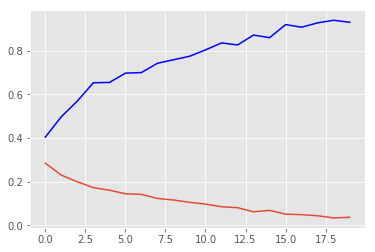

In [151]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')


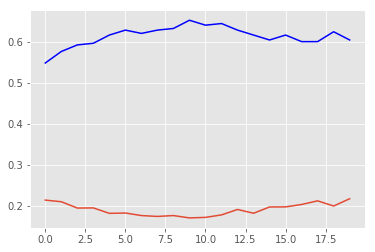

In [152]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')


In [153]:
preds = model.predict_on_batch(X_test)

In [154]:
valence_preds = pd.DataFrame({"Prediction Neg":preds[:,0], "Prediction Pos":preds[:,1], "Prediction Neu":preds[:,2], "Neg":y_test_binary[:,0], "Pos":y_test_binary[:,1], "Neu": y_test_binary[:,2]})
valence_preds.head()

,Prediction Neg,Prediction Pos,Prediction Neu,Neg,Pos,Neu
0,4.921188e-01,0.008075,0.499807,0.0,0.0,1.0
1,4.338863e-01,0.478607,0.087507,0.0,1.0,0.0
2,3.886275e-06,0.999980,0.000016,0.0,0.0,1.0
3,5.824646e-04,0.000559,0.998858,0.0,0.0,1.0
4,9.220767e-07,0.000005,0.999994,0.0,0.0,1.0


## RNN: Strong Pos/Neg Labels

In [163]:
y = valence_df['label'].loc[(valence_df['label']==0)|(valence_df['label']==1)]
X = corpus_df['text'].loc[y.index]


tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
sequences = tokenizer.texts_to_sequences(X)
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [164]:
random.seed(3)
train_list = np.random.choice(range(0,738), size=553, replace=False)
test_list = [i for i in range(0,738) if i not in train_list]

X_train = padded_X[train_list]
X_test = padded_X[test_list]

# labels one hot encoded
y_train = (y.iloc[train_list]).values
y_test = (y.iloc[test_list]).values

y_train_binary = keras.utils.to_categorical(y_train, 2)
y_test_binary = keras.utils.to_categorical(y_test, 2)

X_train

model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train_binary,
                    epochs=25,
                    batch_size=75,
                    validation_data=(X_test, y_test_binary))



Train on 553 samples, validate on 185 samples
Epoch 1/25
553/553 [==============================] - 11s 20ms/step - loss: 0.3485 - acc: 0.5298 - val_loss: 0.2890 - val_acc: 0.5514
Epoch 2/25
553/553 [==============================] - 0s 471us/step - loss: 0.2641 - acc: 0.6293 - val_loss: 0.2814 - val_acc: 0.5730
Epoch 3/25
553/553 [==============================] - 0s 470us/step - loss: 0.2126 - acc: 0.7071 - val_loss: 0.2771 - val_acc: 0.5892
Epoch 4/25
553/553 [==============================] - 0s 475us/step - loss: 0.1691 - acc: 0.7685 - val_loss: 0.2944 - val_acc: 0.5676
Epoch 5/25
553/553 [==============================] - 0s 482us/step - loss: 0.1386 - acc: 0.7993 - val_loss: 0.2931 - val_acc: 0.5838
Epoch 6/25
553/553 [==============================] - 0s 490us/step - loss: 0.1104 - acc: 0.8553 - val_loss: 0.2928 - val_acc: 0.5784
Epoch 7/25
553/553 [==============================] - 0s 482us/step - loss: 0.0855 - acc: 0.8734 - val_loss: 0.3009 - val_acc: 0.5838
Epoch 8/25
553/5

In [165]:
model.evaluate(X_test, y_test_binary)


185/185 [==============================] - 0s 284us/step


[0.33092121941012304, 0.6162162200824635]

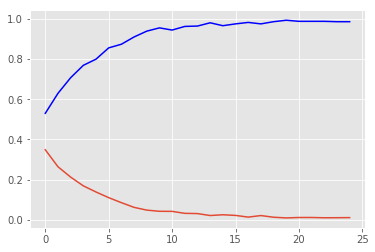

In [166]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')


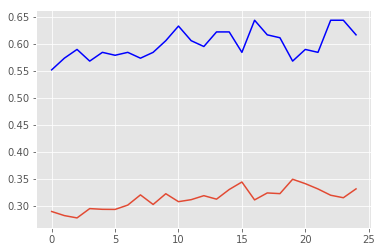

In [167]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')


In [168]:

preds = model.predict_on_batch(X_test)

valence_preds = pd.DataFrame({"Prediction Neg":preds[:,0], "Prediction Pos":preds[:,1]})
valence_preds.head()

,Prediction Neg,Prediction Pos
0,0.648719,0.351281
1,0.017377,0.982623
2,0.999178,0.000822
3,0.983497,0.016503
4,0.000016,0.999984
